In [1]:
import torchvision
from torch import nn
from torchvision.models.feature_extraction import create_feature_extractor
from torch import nn
import torch.nn.functional as F

class ConvTwoToOne(nn.Module):
    def __init__(self, final_shape=(80, 80)):
        super(ConvTwoToOne, self).__init__()

        super().__init__()

        # Load a pretrained ResNet model
        backbone = torchvision.models.resnet50(pretrained=True)

        for param in backbone.parameters():
            param.requires_grad = True


        self.pre_extract = torch.nn.Conv2d(in_channels=1, out_channels=3, kernel_size=1, stride=1, padding=1)
        self.encoder = create_feature_extractor(backbone, return_nodes={'layer4': 'features'})
        # Define your decoder to match the output feature size of 'features'
        self.decoder = nn.Sequential(
            nn.Linear(24576, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 80 * 80),
        )
        
        self.fl = nn.Flatten()

    def forward(self, x1, x2):
        bs = x1.size()[0]
        
        x1 = self.encoder(self.pre_extract(x1))['features']
        x2 = self.encoder(self.pre_extract(x2))['features']
                
        x = torch.cat([x1, x2], dim=1)
        x = self.fl(x)
        x = self.decoder(x)
        x = x.view(bs, 1, 80, 80)
        
        

        return x
    
    
def test_model():
    device = torch.device('cpu')
    model = ConvTwoToOne().to(device)
    inp1 = torch.randn((4, 1, 80, 40), device=device)
    inp2 = torch.randn((4, 1, 80, 40), device=device)

    with torch.no_grad():
      print(model(inp1, inp2).size())
        
    print("params", sum(p.numel() for p in model.parameters() if p.requires_grad))


#test_model()



In [ ]:
from models import diffusion_models

model = diffusion_models.Decoder(ch=)

In [2]:
from applications.poly_features_environment import PolyFeaturesEnv
import torch
import models
from common.fstream import read_tensor, read_matrix, rescale_array


In [3]:
PATH_BASE = "/home/amedvedev/projects/python/DenoisingCNN"
NAME_DATASET = "gcg19"
env = PolyFeaturesEnv(name_model="model_18", name_dataset=NAME_DATASET, path_base=PATH_BASE,
                      device="cuda:0")


env \
    .set_batch_size(4) \
    \
    .load_feature(
        width=40, height=80, feature_name="Uvych_abs_left.xls", mapper=read_matrix
    ) \
    .load_feature(
        width=40, height=80, feature_name="Uvych_abs_right.xls", mapper=read_matrix
    ) \
    .set_target(
        width=80, height=80, target_name="K_abs.xls", mapper=read_tensor
    ) \
    

print(env.train_count)
print(env.val_count)


231
16


In [7]:
env.init_model(ConvTwoToOne)

/home/amedvedev/projects/python/DenoisingCNN/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/amedvedev/projects/python/DenoisingCNN/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


New model created.


In [4]:
env.load_model(model_type="pt")

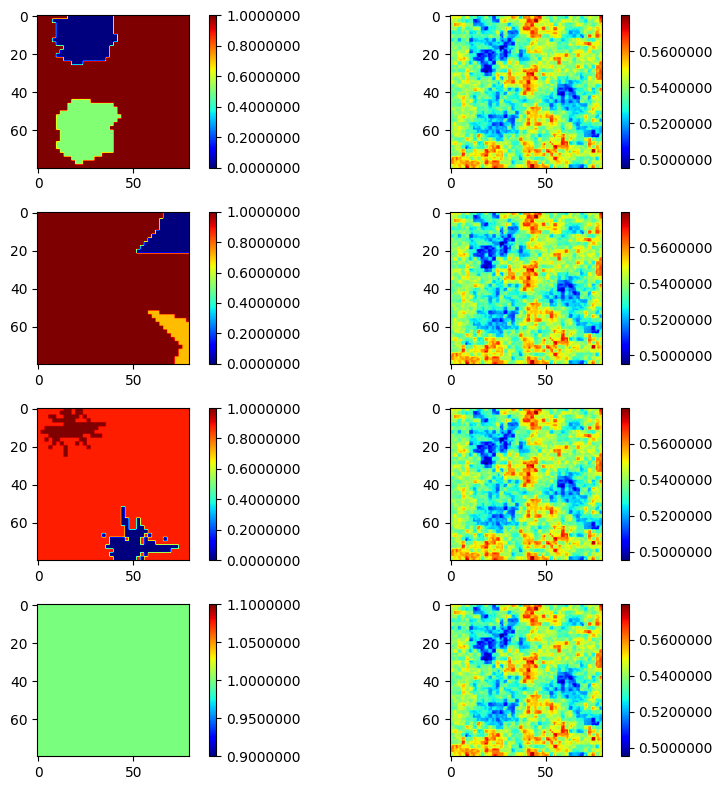

In [7]:
env.plot_batch(6)

In [6]:
env.train(5, step_saving=True, step_plotting=False,
          optimizer=torch.optim.Adam(env.model.parameters(), lr=0.01), 
          criterion=torch.nn.L1Loss())

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 1 	Training Loss: 0.480399 	Validating Loss: 0.276431 	Time: 1.87 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 2 	Training Loss: 0.265048 	Validating Loss: 0.253016 	Time: 1.93 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 3 	Training Loss: 0.252079 	Validating Loss: 0.253096 	Time: 1.91 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 4 	Training Loss: 0.2

In [9]:
import gc
gc.collect()


88951

In [8]:
env.model.cpu()
del env.model

torch.cuda.empty_cache()

In [18]:
torch.cuda.empty_cache()